In [1]:
from landlab.io import read_esri_ascii
import numpy as np

from matplotlib import pyplot as plt

from landlab import RasterModelGrid, imshow_grid
from landlab.components import (
    ChannelProfiler,
    ChiFinder,
    FlowAccumulator,
    SteepnessFinder,
    StreamPowerEroder,
)


In [2]:
(mg, z) = read_esri_ascii("land_pre_river_natural.asc", name="topographic__elevation")

#https://landlab.readthedocs.io/en/master/user_guide/field_io.html

(_, K_sp) = read_esri_ascii("ksp_coeff_nonan.asc")
(_, uplift_rate) = read_esri_ascii("uplift_coeff_metre_p_year_nonan.asc")
#uplift_rate = np.ones(mg.number_of_nodes) * 0.0001

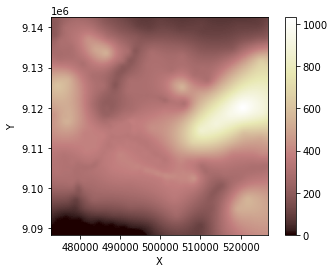

In [3]:
%matplotlib inline
min_z = np.min(z[np.where(z != 1.70141000000000007E+38)])
max_z = np.max(z[np.where(z != 1.70141000000000007E+38)])
#help(imshow_grid)
imshow_grid(mg, 'topographic__elevation', limits=(min_z, max_z))

In [4]:
z[np.where(z == 1.70141000000000007E+38)] = np.nan
K_sp[np.where(K_sp == 1.70141000000000007E+38)] = 0
uplift_rate[np.where(uplift_rate == 1.70141000000000007E+38)] = 0

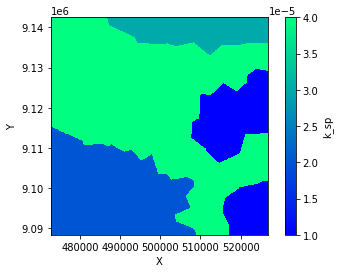

In [5]:
k_field = mg.add_field('linear_diffusivity', K_sp, at='node', clobber=True)
imshow_grid(mg, K_sp, var_name='k_sp', cmap='winter')

In [6]:
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
#mg.set_nodata_nodes_to_closed(z, -9)
#mg.status_at_node[4087] = mg.BC_NODE_IS_FIXED_VALUE
#mg.status_at_node[19] = mg2.BC_NODE_IS_FIXED_VALUE

In [7]:
tmax = 1e5  # time for the model to run [yr] (Original value was 5E5 yr)
dt = 5000 # time step [yr] (Original value was 100 yr)
total_time = 0  # amount of time the landscape has evolved [yr]
# total_time will increase as you keep running the code.

t = np.arange(0, tmax, dt)  # each of the time steps that the code will run

In [8]:
m_sp = 0.5  # exponent on drainage area in stream power equation
n_sp = 1.0  # exponent on slope in stream power equation

frr = FlowAccumulator(mg, flow_director="FlowDirectorD8", depression_finder="DepressionFinderAndRouter")  # intializing flow routing
spr = StreamPowerEroder(
    mg, K_sp=K_sp, m_sp=m_sp, n_sp=n_sp, threshold_sp=0.0
)  # initializing stream power incision

theta = m_sp / n_sp
# initialize the component that will calculate channel steepness
sf = SteepnessFinder(mg, reference_concavity=theta, min_drainage_area=1000.0)
# initialize the component that will calculate the chi index
cf = ChiFinder(mg, min_drainage_area=100.0, reference_concavity=theta, use_true_dx=True)

In [9]:
for ti in t:
    z[mg.core_nodes] += uplift_rate[mg.core_nodes] * dt  # uplift the landscape
    frr.run_one_step()  # route flow
    spr.run_one_step(dt)  # fluvial incision
    total_time += dt  # update time keeper
    print(total_time)

Maximum elevation is  1137.69921688


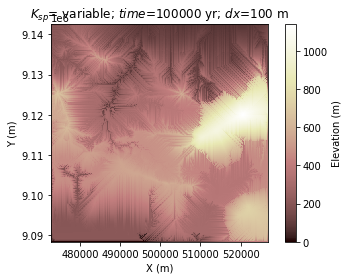

In [10]:
min_z = np.nanmin(z)
max_z = np.nanmax(z)

imshow_grid(mg, "topographic__elevation", grid_units=("m", "m"), var_name="Elevation (m)", limits=(min_z, max_z))
title_text = f"$K_{{sp}}$= variable; $time$={total_time} yr; $dx$=100 m"
plt.title(title_text)

max_elev = np.nanmax(z)
print("Maximum elevation is ", np.nanmax(z))

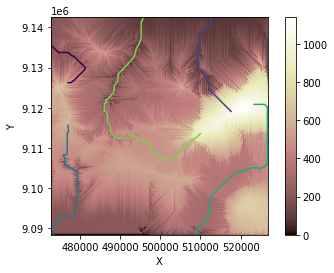

In [11]:
# profile the largest channels, set initially to find the mainstem channel in the three biggest watersheds
# you can change the number of watersheds, or choose to plot all the channel segments in the watershed that
# have drainage area below the threshold (here we have set the threshold to the area of a grid cell).
prf = ChannelProfiler(
    mg,
    number_of_watersheds=5,
    main_channel_only=True,
    minimum_channel_threshold=10 ** 2,
)
prf.run_one_step()

# plot the location of the channels in map view
plt.figure(2)
prf.plot_profiles_in_map_view()